In [208]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans

csv understanding

*   0--> Shape
*   1--> Direction
*   2-->x axis
*   2-->y axis

In [209]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs
a=read_csv('Test Dataset/isolated.csv')


Calculates Aspect Ratio


In [210]:
def calculate_aspect_ratio(points):
    hull = ConvexHull(points)
    hull_points = hull.points[hull.vertices]

    dists = [np.linalg.norm(hull_points[i] - hull_points[(i + 1) % len(hull_points)]) for i in range(len(hull_points))]
    width, height = sorted(dists)[:2]

    return max(width, height) / min(width, height)


In [211]:

def calculate_perimeter(hull):
    perimeter = 0
    for i in range(len(hull.vertices)):
        p1 = hull.points[hull.vertices[i]]
        p2 = hull.points[hull.vertices[(i + 1) % len(hull.vertices)]]
        perimeter += np.linalg.norm(p1 - p2)
    return perimeter

identify a given shape

In [212]:
def identify_shape(points):
    print(len(points))
    if len(points) < 3:
        return 'unknown'
    hull = ConvexHull(points)
    hull_area = hull.volume
    hull_perimeter = calculate_perimeter(hull)

    if hull_perimeter == 0:
        return 'unknown'

    compactness = 4 * np.pi * hull_area / (hull_perimeter ** 2)



    aspect_ratio = calculate_aspect_ratio(points)
    num_vertices = len(hull.vertices)

    print(f"Compactness: {compactness}, Hull Area: {hull_area}, Hull Perimeter: {hull_perimeter},Aspect Ratio: {aspect_ratio}, num_vertices: {num_vertices}")






    if compactness > 0.88:
        print("Identified as circle")
        return 'circle'

    if 1.2<= aspect_ratio <= 2 and compactness<0.75:
        print("Identified as Triangle")
        return 'Triangle'
    if 0.8 < aspect_ratio < 1.2 and compactness>0.75:
        print("Identified as rectangle")
        return 'rectangle'
    if compactness < 0.8 and 0.8 < aspect_ratio < 1.2:
        print("Identified as ellipse")

        return 'ellipse'
    if compactness < 0.1 and aspect_ratio > 4:
        print("Identified as line")
        return 'line'
    if 0.1 < compactness < 0.3 and aspect_ratio > 2:
        print("Identified as arc")
        return 'arc'

    if aspect_ratio > 10000:
        print("identified as star")
        return 'star'
    if num_vertices == 5:
        print("Identified as pentagon")
        return 'pentagon'
    if num_vertices == 6:
        print("Identified as hexagon")
        return 'hexagon'
    if num_vertices == 7:
        print("Identified as heptagon")
        return 'heptagon'
    if num_vertices == 8:
        print("Identified as octagon")
        return 'octagon'
    if num_vertices == 9:
        print("Identified as nonagon")
        return 'nonagon'
    if num_vertices == 10:
        print("Identified as decagon")
        return 'decagon'

    if num_vertices>=10:
        print("Identified as polygon")
        return 'polygon'
    if compactness < 0.9 and 0.8 < aspect_ratio < 1.2 and num_vertices >= 4 and num_vertices <= 8:
        print("Identified as rounded rectangle")
        return 'rounded_rectangle'

    else:
        print("Identified as irregular")
        return 'irregular'




separates points into two categories: those located near the boundaries (outer points) and those within a margin from the boundaries (inner points).

In [213]:
def separate_shapes(fragments):
    all_points = np.concatenate(fragments)

    min_x, min_y = np.min(all_points, axis=0)
    max_x, max_y = np.max(all_points, axis=0)

    margin = 5

    outer_points = []
    inner_points = []

    for point in all_points:
        if (point[0] <= min_x + margin or point[0] >= max_x - margin or
            point[1] <= min_y + margin or point[1] >= max_y - margin):
            outer_points.append(point)
        else:
            inner_points.append(point)

    return np.array(outer_points), np.array(inner_points)

 function calculates the bounding rectangle for a given set of 2D points. This rectangle is defined by the minimum and maximum coordinates and is returned as a list of vertices.

In [214]:
def fit_rectangle(points):
    if points.shape[1] != 2:
        raise ValueError("Input points must be a 2D array with shape (n, 2).")


    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)


    return [
        (min_x, min_y),  # Bottom-left
        (max_x, min_y),  # Bottom-right
        (max_x, max_y),  # Top-right
        (min_x, max_y),  # Top-left
        (min_x, min_y)   # Closing the rectangle
    ]


calculates the best-fit circle for a set of 2D points by finding the circle's center and radius, then generates a set of points representing the circle

In [215]:
def fit_circle(points,num_points=100  ):
    if points.shape[1] != 2:
        raise ValueError("Input points must be a 2D array with shape (n, 2).")
    if points.shape[0] < 1:
        raise ValueError("At least one point is required to fit a circle.")

    center = np.mean(points, axis=0)

    radius = np.mean(np.linalg.norm(points - center, axis=1))

    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = [(center[0] + radius * np.cos(t), center[1] + radius * np.sin(t)) for t in theta]

    return circle_points, tuple(center), radius

 fits a Bézier curve to a set of 2D points using spline interpolation.

In [216]:

def fit_bezier_curve(points,num_points=100):
    try:
        points = np.array(points)
        if points.shape[1] != 2:
            raise ValueError("Input points must be a 2D array with shape (n, 2).")

        unique_points = np.unique(points, axis=0)

        if len(unique_points) < 4:
            print("Not enough unique points to fit a Bézier curve.")
            return None

        tck, _ = splprep(unique_points.T, s=0, k=min(3, len(unique_points) - 1))

        u_new = np.linspace(0, 1, num_points)
        x_new, y_new = splev(u_new, tck)

        return list(zip(x_new, y_new))

    except Exception as e:
        print(f"Error fitting Bézier curve: {e}")
        return None

filters a set of 2D points to return only those within a specified circle

In [217]:
def filter_points_within_circle(points, center, radius):
    if not isinstance(points, np.ndarray) or points.shape[1] != 2:
        raise ValueError("Points must be a 2D numpy array with shape (n, 2).")
    if not isinstance(center, (tuple, list)) or len(center) != 2:
        raise ValueError("Center must be a tuple or list with two elements (x, y).")
    if not isinstance(radius, (int, float)) or radius <= 0:
        raise ValueError("Radius must be a positive number.")

    center = np.array(center)

    distances = np.sqrt(np.sum((points - center) ** 2, axis=1))

    return points[distances < radius]


several operations to visualize and analyze shapes and Bézier curves in relation to a circle and rectangle.

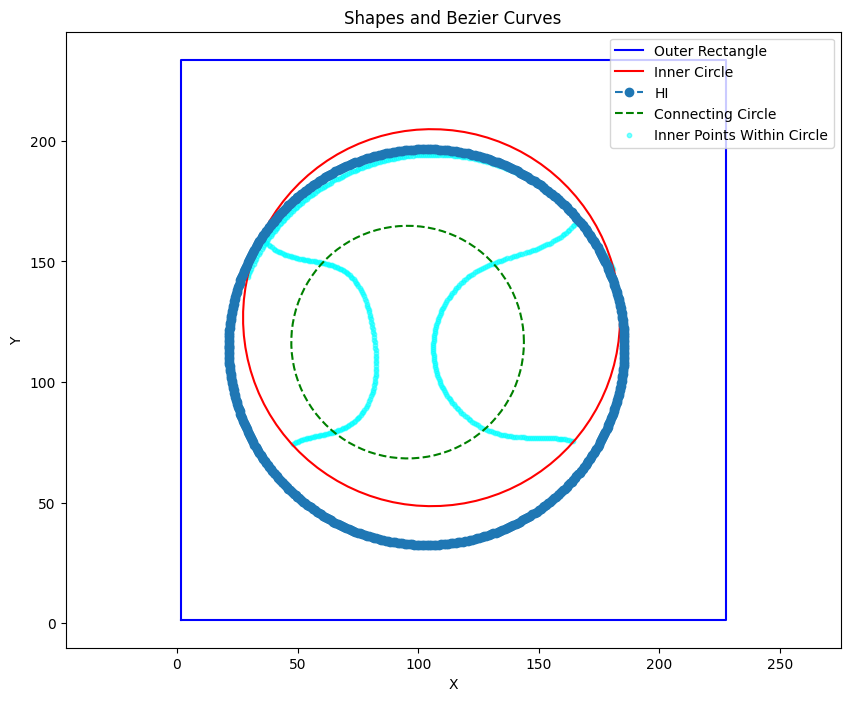

Number of outer points: 650
Number of inner points: 1125
Number of inner points within circle: 555
Average Center: [ 95.61763422 116.55016885]
Average Radius: 48.20560442523089


In [219]:
path_XYs = read_csv('/Test Dataset/frag0.csv')
all_fragments = [fragment for shape_frag in path_XYs for fragment in shape_frag]
path_x = read_csv('/home/krishna/Curvetopia2/Test Dataset/frag01_sol.csv')
outer_points, inner_points = separate_shapes(all_fragments)
rectangle = fit_rectangle(outer_points)
circle, center, radius = fit_circle(inner_points)
inner_points_within_circle = filter_points_within_circle(inner_points, center, radius)
sample_points = inner_points_within_circle 


plt.figure(figsize=(10, 8))

x_rect, y_rect = zip(*rectangle)
plt.plot(x_rect, y_rect, '-', color='blue', label='Outer Rectangle')

x_circle, y_circle = zip(*circle)
plt.plot(x_circle, y_circle, '-', color='red', label='Inner Circle')

plt.plot(sample_points[:, 0], sample_points[:, 1], 'o--', label="HI")

db = DBSCAN(eps=5, min_samples=10).fit(inner_points_within_circle)
labels = db.labels_

bezier_curves = []
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        continue

    cluster_points = inner_points_within_circle[labels == label]
    bezier_curve = fit_bezier_curve(cluster_points)
    if bezier_curve:
        bezier_curves.append(bezier_curve)

ellipse_centers = [np.mean(curve, axis=0) for curve in bezier_curves]
average_center = np.mean(ellipse_centers, axis=0)
average_radius = np.mean([np.mean(np.linalg.norm(np.array(curve) - average_center, axis=1)) for curve in bezier_curves])
theta = np.linspace(0, 2 * np.pi, 100)
connecting_circle = [(average_center[0] + average_radius * np.cos(t), average_center[1] + average_radius * np.sin(t)) for t in theta]

x_connecting_circle, y_connecting_circle = zip(*connecting_circle)
plt.plot(x_connecting_circle, y_connecting_circle, '--', color='green', label='Connecting Circle')

plt.scatter(inner_points_within_circle[:, 0], inner_points_within_circle[:, 1], s=10, color='cyan', alpha=0.5, label='Inner Points Within Circle')

plt.legend()
plt.title("Shapes and Bezier Curves")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

print(f"Number of outer points: {len(outer_points)}")
print(f"Number of inner points: {len(inner_points)}")
print(f"Number of inner points within circle: {len(inner_points_within_circle)}")
print(f"Average Center: {average_center}")
print(f"Average Radius: {average_radius}")